In [7]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *


In [2]:
# Help Functions: 
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}%'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def get_overlap_size(l1, l2):
    return len([g for g in l1 if g in l2])

def extract_top_genes(selected_K, num_top_genes, local_density_threshold, r_number_of_genes, n_replicates):
    topgenes = []
    if selected_K<15:
        RUN_Ks = f'k5_14'
    else:
        RUN_Ks = f'k15_25'
    RUN_NAME = f'{RUN_Ks}_{r_number_of_genes}genes_{n_replicates}iter'
    GENE_SPECTRA_SCORE_PATH = f'{RUN_NAME}.gene_spectra_score.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.txt'
    gene_scores = pd.read_csv(join(EXEC_DIR, RUN_NAME, GENE_SPECTRA_SCORE_PATH), sep='\t', index_col=0).T
    for gep in gene_scores.columns:
        topgenes.append(pd.Series(gene_scores[gep].sort_values(ascending=False).index[:num_top_genes]))
    topgenes = pd.concat(topgenes, axis=1)
    topgenes.columns = ['GEP%d' % g for g in gene_scores.columns]
    return topgenes

def bold(string):
    """
    Return Bold string for print 
    :param string: 
    :return: 
    """
    return '\033[1m' + string + '\033[0m'

def get_RUN_Ks(selected_Ks):
    RUN_Ks = f'k36_40'
    if selected_K<=20:
        RUN_Ks = f'k10_20'
    elif selected_K<=35:
        RUN_Ks = f'k21_35'
    return RUN_Ks 

Loads tumor cohort which used for cNMF runs

In [3]:
# tumor_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/5.21/cohort_normalized_24.5.21.pkl'
# COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21.pkl'
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/5.5.22/cohort_normalized_5.5.22_protein_coding_genes.pkl'

# tumor_cohort = pickle.load(open(tumor_path, 'rb'))
cohort = pickle.load(open(COHORT_PATH, 'rb'))
tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)



Loads tSNE of that tumor cohort

In [4]:
TSNE_PATH = r'/storage/md_keren/shitay/outputs/TSNE/cohort_5.5.22/tumor/tumor_bhtsne_5.5.22.pkl'
cells_embedded = pickle.load(open(TSNE_PATH, 'rb'))


# tsne_results = pd.DataFrame(cells_embedded, index=tumor_cohort.barcodes, columns=['TSNE1', 'TSNE2'])
index = [tumor_cohort.samples[i]+"_"+tumor_cohort.barcodes[i] for i in range(tumor_cohort.number_of_cells)]
tsne_results = pd.DataFrame(cells_embedded, index=index, columns=['TSNE1', 'TSNE2']) 

# Plots programs of many (specified) runs
Arranged by program indexes

In [ ]:
# EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_26.6.21'
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/'
# selected_K = 18
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 10
RUN_Ks = f'k10_40'
COHORT = 'cohort_5.5.22'


first_k = 10
last_k = 40

for selected_K in range(first_k, last_k+1):
    
    #RUN_Ks = get_RUN_Ks(selected_K)
    RUN_NAME = f'{RUN_Ks}_{number_of_genes}genes_{n_replicates}iter'
    USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'


    usage_matrix = pd.read_csv(join(EXEC_DIR, COHORT, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
    usage_matrix.columns = np.arange(1,selected_K+1)
    normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
    normalized_usage_matrix.head()


    fig, axs = plt.subplots(int(np.ceil(selected_K/5)), 5)
    axs = axs.ravel()

    fig.set_size_inches(32, 22)
    for idx, (columnName, columnData) in enumerate(normalized_usage_matrix.iteritems()):
    #     print('Program : ', columnName)
        programs_vals = columnData.values
        df = pd.DataFrame(np.round(programs_vals, 1),columns=['Usage'])
        g = sns.barplot(x="Usage", y="Usage", data=df, estimator=lambda x: len(x) / len(df) * 100, ax=axs[idx]);
        g.set(ylabel="% of the cells");
        g.set_title(f'Program {columnName}')
        show_values_on_bars(g)
    fig.tight_layout()
    if selected_K%5>0:
        for i in range(5-selected_K%5, 0, -1):
            axs[-i].remove()
    
    create_folder(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/{COHORT}/{RUN_Ks}')
    create_folder(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/{COHORT}/{RUN_Ks}/plot1')
    fig.savefig(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/{COHORT}/{RUN_Ks}/plot1/k{selected_K}_cell_usages.jpg')


# Plots programs of one specified run
Arranged by 0.1 uasge

In [ ]:
selected_K = 10



programs_dfs = {}

for column in normalized_usage_matrix.columns:

    programs_vals = np.round(normalized_usage_matrix[column].values, 1)
    curr_program_usage = pd.DataFrame([x/10 for x in range(11)], columns=['Usage'])
    curr_program_usage['val'] = curr_program_usage['Usage'].apply(lambda x: (sum(programs_vals>=x)/len(programs_vals))*100)
    programs_dfs[column] = curr_program_usage
programs_dfs = {k: v for k, v in sorted(programs_dfs.items(), key=lambda item: item[1].iloc[1].val, reverse=True)}

fig, axs = plt.subplots(int(np.ceil(selected_K/5)), 5)
axs = axs.ravel()

fig.set_size_inches(32, 22)
for idx, (columnName, program_df) in enumerate(programs_dfs.items()):
    g = sns.barplot(x="Usage", y="val", data=program_df, ax=axs[idx])#, estimator=lambda x: len(x) / len(df) * 100, ax=axs[idx]);    
    g.set(ylabel="% of the cells");
    g.set_title(f'Program {columnName}')
    show_values_on_bars(g)
fig.tight_layout()
if selected_K%5>0:
    for i in range(5-selected_K%5, 0, -1):
        axs[-i].remove()
# fig.savefig(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/k15_25/k{selected_K}_cell_usages.jpg')

# Plots histgoram of programs of many (specified) runs

Arranged by 0.1 uasge

In [ ]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs'
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 10
COHORT = 'cohort_5.5.22'
first_k = 10
last_k = 40
RUN_Ks = f'k10_40'


for selected_K in range(first_k, last_k+1):
#     RUN_Ks = get_RUN_Ks(selected_K)
    RUN_NAME = f'{RUN_Ks}_{number_of_genes}genes_{n_replicates}iter'
    USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'


    usage_matrix = pd.read_csv(join(EXEC_DIR, COHORT, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
    usage_matrix.columns = np.arange(1,selected_K+1)
    normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
    normalized_usage_matrix.head()

    tsne_and_usages = pd.merge(left=normalized_usage_matrix, right=tsne_results, left_index=True, right_index=True)

    programs_dfs = {}

    for column in normalized_usage_matrix.columns:

        programs_vals = np.round(normalized_usage_matrix[column].values, 1)
        curr_program_usage = pd.DataFrame([x/10 for x in range(11)], columns=['Usage'])
        curr_program_usage['val'] = curr_program_usage['Usage'].apply(lambda x: (sum(programs_vals>=x)/len(programs_vals))*100)
        programs_dfs[column] = curr_program_usage
    programs_dfs = {k: v for k, v in sorted(programs_dfs.items(), key=lambda item: item[1].iloc[1].val, reverse=True)}

    fig, axs = plt.subplots(int(np.ceil(selected_K/5)), 5)
    axs = axs.ravel()

    fig.set_size_inches(32, 22)
    for idx, (columnName, program_df) in enumerate(programs_dfs.items()):
        g = sns.barplot(x="Usage", y="val", data=program_df, ax=axs[idx])#, estimator=lambda x: len(x) / len(df) * 100, ax=axs[idx]);    
        g.set(ylabel="% of the cells");
        g.set_title(f'Program {columnName}')
        show_values_on_bars(g)
    fig.tight_layout()
    if selected_K%5>0:
        for i in range(5-selected_K%5, 0, -1):
            axs[-i].remove()
    create_folder(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/{COHORT}/{RUN_Ks}')
    create_folder(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/{COHORT}/{RUN_Ks}/plot2')
    fig.savefig(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/{COHORT}/{RUN_Ks}/plot2/k{selected_K}_cell_usages.jpg')

# Number of non-empty programs in each solution
looking at the % of cells in each usage value.

we build 3 tables:
1. For each K (k programs) the number of programs that > 5%  of the cells their usage value is 0.1|0.2|0.3 ... | 0.9|1
1. For each K (k programs) the number of programs that > 10% of the cells their usage value is 0.1|0.2|0.3 ... | 0.9|1
1. For each K (k programs) the number of programs that > 20% of the cells their usage value is 0.1|0.2|0.3 ... | 0.9|1

In [5]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs'
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 10
COHORT = 'cohort_5.5.22'
first_k = 10
last_k = 40
RUN_Ks = r'k10_40'


significant_5_df = pd.DataFrame(columns=range(11))
significant_10_df = pd.DataFrame(columns=range(11))
significant_20_df = pd.DataFrame(columns=range(11))

for selected_K in range(first_k, last_k+1):
    print(f'K={selected_K}', end=' ')
#     if selected_K > 35:
#         n_replicates = 20
#     RUN_Ks = get_RUN_Ks(selected_K)
    RUN_NAME = f'{RUN_Ks}_{number_of_genes}genes_{n_replicates}iter'
    USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'


    usage_matrix = pd.read_csv(join(EXEC_DIR, COHORT, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
    usage_matrix.columns = np.arange(1,selected_K+1)
    normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
    normalized_usage_matrix.head()

    tsne_and_usages = pd.merge(left=normalized_usage_matrix, right=tsne_results, left_index=True, right_index=True)

    programs_dfs = {}

    for column in normalized_usage_matrix.columns:

        programs_vals = np.round(normalized_usage_matrix[column].values, 1)
        curr_program_usage = pd.DataFrame([x/10 for x in range(11)], columns=['Usage'])
        curr_program_usage['val'] = curr_program_usage['Usage'].apply(lambda x: (sum(programs_vals>=x)/len(programs_vals))*100)
        programs_dfs[column] = curr_program_usage
    programs_dfs = {k: v for k, v in sorted(programs_dfs.items(), key=lambda item: item[1].iloc[1].val, reverse=True)}
    
    
    significant_5 = (programs_dfs[1].val>5).astype(int)
    significant_10 = (programs_dfs[1].val>10).astype(int)
    significant_20 = (programs_dfs[1].val>20).astype(int)
    for i in range(2, selected_K+1):
        significant_5 += (programs_dfs[i].val>5).astype(int)
        significant_10 += (programs_dfs[i].val>10).astype(int)
        significant_20 += (programs_dfs[i].val>20).astype(int)

    significant_5_df = significant_5_df.append(pd.DataFrame([significant_5/selected_K], columns=range(11), index=[selected_K]))
    significant_10_df = significant_10_df.append(pd.DataFrame([significant_10/selected_K], columns=range(11), index=[selected_K]))
    significant_20_df = significant_20_df.append(pd.DataFrame([significant_20/selected_K], columns=range(11), index=[selected_K]))

    

K=10 K=11 K=12 K=13 K=14 K=15 K=16 K=17 K=18 K=19 K=20 K=21 K=22 K=23 K=24 K=25 K=26 K=27 K=28 K=29 K=30 K=31 K=32 K=33 K=34 K=35 K=36 K=37 K=38 K=39 K=40 

#### Plot grap of non-empty programs: 

In [6]:
COHORT = f'cohort_5.5.22'
RUN_Ks = f'k10_40'
OUTPUT_FOLDER = join(f'/storage/md_keren/shitay/outputs/cNMF/summary', COHORT, RUN_Ks)

create_folder(OUTPUT_FOLDER)

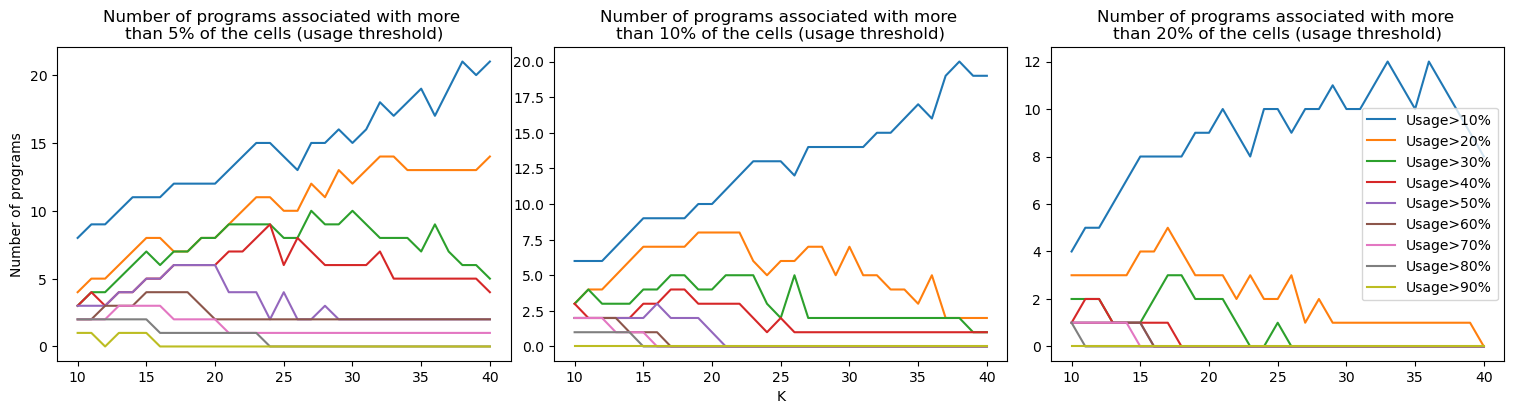

In [8]:
sig_dfs = {5: significant_5_df, 10: significant_10_df, 20: significant_20_df}

plt.rcdefaults()  # reset params
(fig,axes) = plt.subplots(1,3, figsize=(15,4))

for idx, sig_lvl in enumerate([5, 10, 20]):
    vals = (np.array(range(10,41)) * sig_dfs[sig_lvl].T).T
    for i in range(1, 10):
        axes[idx].plot(range(10,41), vals[i], label=f'Usage>{round(i*10,2)}%')
    axes[idx].set(title=f"Number of programs associated with more \nthan {sig_lvl}% of the cells (usage threshold)");

axes[2].legend();
axes[0].set(ylabel='Number of programs')    
axes[1].set(xlabel='K')
plt.tight_layout(pad=0.2)
plt.savefig(join(OUTPUT_FOLDER, f'non_empty_programs.png'))

In [11]:
OUTPUT_FOLDER

'/storage/md_keren/shitay/outputs/cNMF/summary/cohort_5.5.22/k10_40'

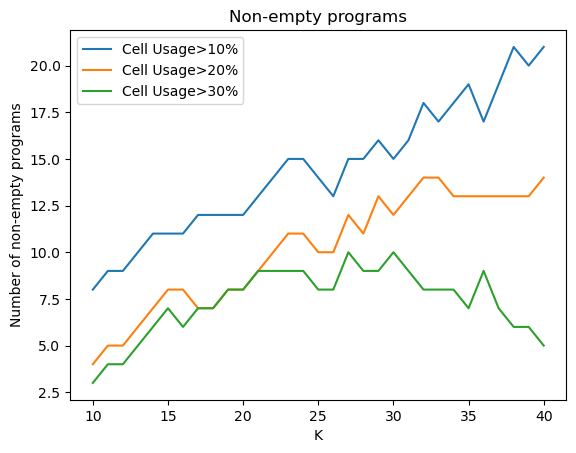

In [12]:
vals = (np.array(range(10,41)) * significant_5_df.T).T

for i in range(1, 4):
    plt.plot(range(10,41), vals[i], label=f'Cell Usage>{i*10}%')

plt.legend();
plt.ylabel('Number of non-empty programs')
plt.xlabel('K')
plt.title(f"Non-empty programs");
plt.savefig(join(OUTPUT_FOLDER, f'THESIS_non_empty_programs.png'))

In [40]:
significant_5_df.to_csv('/storage/md_keren/shitay/outputs/cNMF/visualizations/cohort_4.11.21/sig_5.csv', index=False)
significant_10_df.to_csv('/storage/md_keren/shitay/outputs/cNMF/visualizations/cohort_4.11.21/sig_10.csv', index=False)
significant_20_df.to_csv('/storage/md_keren/shitay/outputs/cNMF/visualizations/cohort_4.11.21/sig_20.csv', index=False)

# Different runs (Ks), overlaps of top genes
Takes two runs (different number of programs (k)) and present the overlap of the top genes of all pair-wise programs.

Then, identifies which programs for each K don't have any equivalent programs (low overlap) with the second run, and print the number of genes in the overlap.  

In [10]:
selected_K = 5
selected_K_2 = 9


topgenes = []
topgenes2 = []
num_top_genes=250
min_overlap_genes = 180

EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_10.6.21'
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 10

print(f'Search min overlap of genes between programs of K={selected_K} and K={selected_K_2}')
print(f'Looking at the first {num_top_genes} top genes, where the min overlap of genes defined as {min_overlap_genes}\n\n')

# k_1
topgenes = extract_top_genes(selected_K, num_top_genes, local_density_threshold, number_of_genes, n_replicates)

# k_2
topgenes2 = extract_top_genes(selected_K_2, num_top_genes, local_density_threshold, number_of_genes, n_replicates)


overlaps_sizes = [[get_overlap_size(pi, pj) for pi in topgenes.values.T.tolist()] for pj in topgenes2.values.T.tolist()]

df = pd.DataFrame(overlaps_sizes, columns=range(1,selected_K+1), index=range(1,selected_K_2+1))


max_overlap_sizes_0 = np.max(overlaps_sizes, axis=0)
max_overlap_sizes_1 = np.max(overlaps_sizes, axis=1)

overlap_size_order = np.argsort(max_overlap_sizes_0)
small_overlaps = max_overlap_sizes_0[overlap_size_order] < min_overlap_genes
print(f'Programs of K={selected_K}')
print(f'Min #genes in overlap: {max_overlap_sizes_0[overlap_size_order][small_overlaps]}')
print(f'Of programs (K={selected_K}, K={selected_K_2}): {list(zip(overlap_size_order[small_overlaps]+1, (np.argmax(overlaps_sizes, axis=0)[overlap_size_order][small_overlaps]+1)))} respectively.\n')

overlap_size_order = np.argsort(max_overlap_sizes_1)
small_overlaps = max_overlap_sizes_1[overlap_size_order] < min_overlap_genes
print(f'Programs of K={selected_K_2}')
print(f'Min #genes in overlap: {max_overlap_sizes_1[overlap_size_order][small_overlaps]}')
print(f'Of programs (K={selected_K_2}, K={selected_K}): {list(zip(overlap_size_order[small_overlaps]+1, (np.argmax(overlaps_sizes, axis=1)[overlap_size_order][small_overlaps]+1)))} respectively.\n')
df

Search min overlap of genes between programs of K=5 and K=9
Looking at the first 250 top genes, where the min overlap of genes defined as 180


Programs of K=5
Min #genes in overlap: [84]
Of programs (K=5, K=9): [(5, 9)] respectively.

Programs of K=9
Min #genes in overlap: [ 3 23 39 67 84]
Of programs (K=9, K=5): [(4, 1), (3, 2), (1, 3), (5, 5), (9, 5)] respectively.



,1,2,3,4,5
1,13,26,39,9,3
2,8,2,4,236,4
3,5,23,5,3,2
4,3,2,3,2,2
5,1,1,3,16,67
6,245,1,20,9,0
7,21,5,243,6,1
8,1,235,4,3,1
9,1,0,0,6,84


Does the same only for overlap of genes between programs of sequential Ks:

In [8]:
first_k = 5
last_k = 25

num_top_genes=250
min_overlap_genes = 180

print(f'Search min overlap of genes between programs of sequential Ks')
print(f'First K={first_k}, last K={last_k}')
print(f'Looking at the first {num_top_genes} top genes, where the min overlap of genes defined as {min_overlap_genes}\n\n')

for selected_K in range(first_k, last_k):
    print(bold(f'Comparing programs of k={selected_K} and k={selected_K+1}:'))
    
    # k_1
    topgenes = extract_top_genes(selected_K, num_top_genes, local_density_threshold, number_of_genes, n_replicates)

    # k_2
    topgenes2 = extract_top_genes(selected_K+1, num_top_genes, local_density_threshold, number_of_genes, n_replicates)


    overlaps_sizes = [[get_overlap_size(pi, pj) for pi in topgenes.values.T.tolist()] for pj in topgenes2.values.T.tolist()]

    max_overlap_sizes_0 = np.max(overlaps_sizes, axis=0)
    max_overlap_sizes_1 = np.max(overlaps_sizes, axis=1)

    overlap_size_order = np.argsort(max_overlap_sizes_0)
    small_overlaps = max_overlap_sizes_0[overlap_size_order] < min_overlap_genes
    print(f'Programs of K={selected_K}')
    print(f'Min #genes in overlap: {max_overlap_sizes_0[overlap_size_order][small_overlaps]}')
    print(f'Of programs (K={selected_K}, K={selected_K+1}): {list(zip(overlap_size_order[small_overlaps]+1, (np.argmax(overlaps_sizes, axis=0)[overlap_size_order][small_overlaps]+1)))} respectively.\n')

    overlap_size_order = np.argsort(max_overlap_sizes_1)
    small_overlaps = max_overlap_sizes_1[overlap_size_order] < min_overlap_genes
    print(f'Programs of K={selected_K+1}')
    print(f'Min #genes in overlap: {max_overlap_sizes_1[overlap_size_order][small_overlaps]}')
    print(f'Of programs (K={selected_K+1}, K={selected_K}): {list(zip(overlap_size_order[small_overlaps]+1, (np.argmax(overlaps_sizes, axis=1)[overlap_size_order][small_overlaps]+1)))} respectively.\n')

Search min overlap of genes between programs of sequential Ks
First K=5, last K=25
Looking at the first 250 top genes, where the min overlap of genes defined as 180


Comparing programs of k=5 and k=6:
Programs of K=5
Min #genes in overlap: [113]
Of programs (K=5, K=6): [(5, 1)] respectively.

Programs of K=6
Min #genes in overlap: [ 63 113]
Of programs (K=6, K=5): [(6, 5), (1, 5)] respectively.

Comparing programs of k=6 and k=7:
Programs of K=6
Min #genes in overlap: [83 95]
Of programs (K=6, K=7): [(1, 2), (6, 2)] respectively.

Programs of K=7
Min #genes in overlap: [ 4 29 95]
Of programs (K=7, K=6): [(7, 4), (6, 2), (2, 6)] respectively.

Comparing programs of k=7 and k=8:
Programs of K=7
Min #genes in overlap: [98]
Of programs (K=7, K=8): [(2, 7)] respectively.

Programs of K=8
Min #genes in overlap: [64 98]
Of programs (K=8, K=7): [(8, 2), (7, 2)] respectively.

Comparing programs of k=8 and k=9:
Programs of K=8
Min #genes in overlap: []
Of programs (K=8, K=9): [] respectively.


Tracks a program over all Ks:
present the idx of a given program for all Ks.

In [9]:
first_k = 5
program_idx = 5

last_k = 25

# k_1
topgenes = extract_top_genes(first_k, num_top_genes, local_density_threshold, number_of_genes, n_replicates)
print(bold(f'Tracks program {program_idx} in k={first_k}\n\n'))
for selected_K in range(first_k+1, last_k+1):
    # k_2
    topgenes2 = extract_top_genes(selected_K, num_top_genes, local_density_threshold, number_of_genes, n_replicates)


    overlaps_sizes = [[get_overlap_size(pi, pj) for pi in topgenes.values.T.tolist()] for pj in topgenes2.values.T.tolist()]

    print(bold(f'K: {selected_K}'))
    print(f'Closet program: {np.argmax(np.array(overlaps_sizes)[:,program_idx-1])+1}')
    print(f'num of genes in overlap: {np.max(np.array(overlaps_sizes)[:,program_idx-1])}\n\n')

Tracks program 5 in k=5


K: 6
Closet program: 1
num of genes in overlap: 113


K: 7
Closet program: 2
num of genes in overlap: 210


K: 8
Closet program: 8
num of genes in overlap: 84


K: 9
Closet program: 9
num of genes in overlap: 84


K: 10
Closet program: 2
num of genes in overlap: 83


K: 11
Closet program: 11
num of genes in overlap: 90


K: 12
Closet program: 2
num of genes in overlap: 100


K: 13
Closet program: 1
num of genes in overlap: 102


K: 14
Closet program: 8
num of genes in overlap: 105


K: 15
Closet program: 1
num of genes in overlap: 101


K: 16
Closet program: 13
num of genes in overlap: 79


K: 17
Closet program: 17
num of genes in overlap: 78


K: 18
Closet program: 2
num of genes in overlap: 78


K: 19
Closet program: 16
num of genes in overlap: 78


K: 20
Closet program: 20
num of genes in overlap: 79


K: 21
Closet program: 20
num of genes in overlap: 81


K: 22
Closet program: 19
num of genes in overlap: 79


K: 23
Closet program: 2
num of genes in overlap

# Debug

In [88]:
first_k = 5
last_k = 25

EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_10.6.21'
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 10
RUN_Ks = f'k5_14'
Ks_programs_df = []

for selected_K in range(first_k, last_k+1):
    if selected_K<15:
        RUN_Ks = f'k5_14'
    else:
        RUN_Ks = f'k15_25'

    
    RUN_NAME = f'{RUN_Ks}_{number_of_genes}genes_{n_replicates}iter'
    USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'


    usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
    usage_matrix.columns = np.arange(1,selected_K+1)
    normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
    normalized_usage_matrix.head()


    programs_dfs = {}

    for column in normalized_usage_matrix.columns:

        programs_vals = np.round(normalized_usage_matrix[column].values, 1)
        curr_program_usage = pd.DataFrame([x/10 for x in range(11)], columns=['Usage'])
        curr_program_usage['val'] = curr_program_usage['Usage'].apply(lambda x: (sum(programs_vals>=x)/len(programs_vals))*100)
        programs_dfs[column] = curr_program_usage
#     programs_dfs = {k: v for k, v in sorted(programs_dfs.items(), key=lambda item: item[1].iloc[1].val, reverse=True)}
    Ks_programs_df.append(programs_dfs)

In [6]:
arr = np.array([[p.values[:,1].tolist() for p in list(programs_df.values())[:first_k]] for programs_df in Ks_programs_df])
# arr

In [7]:
(arr[0] - arr[1])[0]

array([ 0.        ,  3.96817077,  7.16919998, 11.11164054, 15.70591318,
       20.21441845, 23.79758898, 25.97131558, 25.7873922 , 20.84147329,
        9.76032782])

In [8]:
pd.set_option('display.max_columns', None)

program_idx = 1 # ordered by mass, 0 is first
variable_usage = 1 # wich usage to take for comparison, starts with 1 - 1=0.1, 2=0.2, 3=0.3
metrix_size = last_k - first_k + 1

distances = np.zeros((metrix_size, metrix_size))
for i in range(metrix_size):
    for j in range(metrix_size):
        distances[i, j] = (arr[i] - arr[j])[program_idx][variable_usage]
pd.DataFrame(distances, columns = range(first_k, last_k+1), index = range(first_k, last_k+1))

,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
5,0.000000,-4.366513,1.838281,-24.696241,-24.464669,-21.896412,-21.033973,-31.242198,-18.945061,-14.013437,-20.065755,-9.493496,-10.633249,-10.698051,-10.456950,-9.252394,-15.068376,-8.376614,-15.954639,-14.141135,-15.999428
6,4.366513,0.000000,6.204793,-20.329728,-20.098156,-17.529899,-16.667461,-26.875685,-14.578549,-9.646924,-15.699242,-5.126983,-6.266737,-6.331539,-6.090437,-4.885882,-10.701863,-4.010101,-11.588126,-9.774622,-11.632916
7,-1.838281,-6.204793,0.000000,-26.534521,-26.302949,-23.734693,-22.872254,-33.080478,-20.783342,-15.851718,-21.904036,-11.331777,-12.471530,-12.536332,-12.295230,-11.090675,-16.906657,-10.214895,-17.792919,-15.979416,-17.837709
8,24.696241,20.329728,26.534521,0.000000,0.231572,2.799828,3.662267,-6.545957,5.751179,10.682804,4.630486,15.202745,14.062991,13.998189,14.239291,15.443846,9.627865,16.319626,8.741602,10.555106,8.696812
9,24.464669,20.098156,26.302949,-0.231572,0.000000,2.568257,3.430695,-6.777529,5.519607,10.451232,4.398914,14.971173,13.831419,13.766617,14.007719,15.212274,9.396293,16.088055,8.510030,10.323534,8.465240
10,21.896412,17.529899,23.734693,-2.799828,-2.568257,0.000000,0.862439,-9.345785,2.951351,7.882975,1.830657,12.402916,11.263163,11.198361,11.439463,12.644018,6.828036,13.519798,5.941773,7.755277,5.896984
11,21.033973,16.667461,22.872254,-3.662267,-3.430695,-0.862439,0.000000,-10.208224,2.088912,7.020537,0.968218,11.540477,10.400724,10.335922,10.577024,11.781579,5.965598,12.657359,5.079335,6.892838,5.034545
12,31.242198,26.875685,33.080478,6.545957,6.777529,9.345785,10.208224,0.000000,12.297136,17.228761,11.176443,21.748702,20.608948,20.544146,20.785248,21.989803,16.173822,22.865583,15.287559,17.101063,15.242769
13,18.945061,14.578549,20.783342,-5.751179,-5.519607,-2.951351,-2.088912,-12.297136,0.000000,4.931624,-1.120694,9.451565,8.311812,8.247010,8.488112,9.692667,3.876686,10.568447,2.990423,4.803926,2.945633
14,14.013437,9.646924,15.851718,-10.682804,-10.451232,-7.882975,-7.020537,-17.228761,-4.931624,0.000000,-6.052318,4.519941,3.380188,3.315386,3.556487,4.761043,-1.054939,5.636823,-1.941202,-0.127698,-1.985991


P0 - [U0.1: (12-13), (20-21), (20-23)], [U0.2: (5-6), (12-13), (20-21)], [U0.3: (5-6), (5-8), (12-13), (20-21), (20-23)], [U0.4: (5-6), (5-8), (12-13), (15-16), (20-21), (20-23)]
Ks: 5, 12,20 (15)

P1 - [U0.1: (7-8)_,~(11-12), ~(11-13), (15-16)], [U0.2: ~(5-6), ~(5-8)

In [9]:
selected_K =24

In [10]:
GENE_SPECTRA_SCORE_PATH = f'{RUN_NAME}.gene_spectra_score.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.txt'
gene_scores = pd.read_csv(join(EXEC_DIR, RUN_NAME, GENE_SPECTRA_SCORE_PATH), sep='\t', index_col=0)
gene_scores = gene_scores.T
gene_scores.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
TSPAN6,-0.000063,-0.000084,-0.000068,-0.000128,-0.000081,0.000051,-0.000185,-0.000184,-0.000045,0.000280,0.000693,0.000296,-0.000420,0.000052,0.000909,0.000012,-0.000262,-0.000291,0.000164,-0.000028,-0.000188,0.000354,-0.000086,-0.000074
TNMD,0.000004,-0.000122,0.000188,-0.000012,0.001146,0.000062,0.000121,-0.000024,0.000516,0.000086,-0.000010,0.000240,-0.000069,-0.000019,0.000041,0.000048,-0.000060,-0.000176,0.000007,-0.000045,-0.000064,-0.000003,-0.000126,-0.000172
DPM1,0.000012,0.000187,-0.000049,0.000091,0.000112,0.000567,-0.000056,-0.000063,-0.000066,-0.000194,-0.000051,-0.000056,0.000035,-0.000049,0.001304,-0.000064,0.000118,-0.000431,0.000777,-0.000031,-0.000128,0.000501,-0.000810,-0.000066
SCYL3,0.000021,-0.000218,-0.000040,-0.000022,0.000023,0.000227,0.000311,0.000030,-0.000060,-0.000090,0.000097,-0.000017,-0.000013,0.000008,0.000599,0.000317,-0.000046,-0.000310,-0.000057,-0.000142,0.000043,0.000222,0.000195,-0.000056
C1orf112,-0.000044,-0.000193,-0.000067,0.000021,-0.000193,-0.000187,0.000014,0.000189,-0.000081,-0.000491,-0.000057,-0.000015,0.000039,0.001667,0.001031,-0.000090,-0.000143,-0.000558,0.002240,-0.000047,-0.000062,0.000075,-0.000244,-0.000085


In [11]:


# topgenes.head(10)

In [93]:
# programs_dfs

Programs of K=6
Min #genes in overlap: [83 95]
Of programs: [1 6] respectively.

Programs of K=7
Min #genes in overlap: [ 4 29 95]
Of programs: [7 6 2] respectively.



,1,2,3,4,5,6
1,1,5,20,247,5,5
2,83,1,0,1,5,95
3,0,246,1,5,3,1
4,0,1,250,21,9,1
5,6,3,9,5,245,10
6,0,29,5,9,4,2
7,3,2,3,4,2,1


See the min overlaps of all Ks